In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import yaml

import mplhep
import zfit

mplhep.set_style('CMS')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### load image

In [ ]:
with open('fitting_cfg.yml') as f:
    cfg_dict = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
image_path = 'images/-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269.png'
# image_path = 'images/0.7410642504692078__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev447.png'
# image_path = 'images/0.7402061223983765__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev937.png'
# image_path = 'images/-0.3499999940395355__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run2_ev87.png'
# image_path = 'images/0.48575398325920105__CYGNO_60_40_ER_1_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev0.png'
# image_path = 'images/3.1136999130249023__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run1_ev809.png'

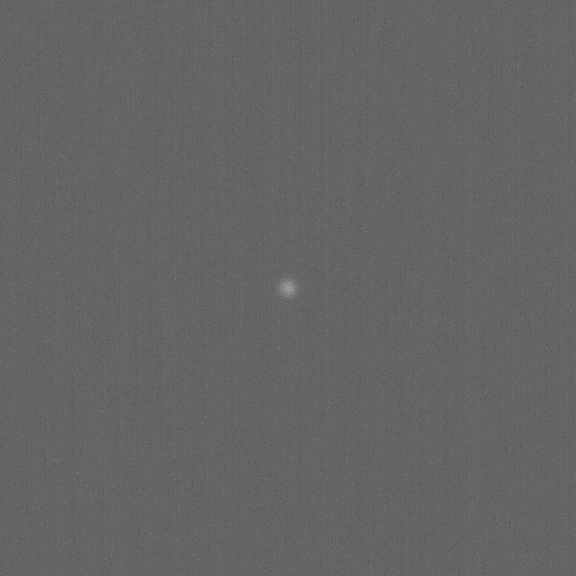

In [5]:
im = Image.open(image_path)
im

In [28]:
obs_left, obs_right = cfg_dict['obs']['range']
obs_grid = np.linspace(obs_left, obs_right, 1000)
n_bins = cfg_dict['obs']['n_bins']
obs_edges = np.array(range(obs_left, obs_right + 1))
obs_bin_centers = (obs_edges[:-1] + obs_edges[1:])/2

In [7]:
obs = zfit.Space("obs", limits=(obs_left, obs_right))

In [8]:
ima = np.array(im)
ima_x = np.sum(ima[obs_left:obs_right, obs_left:obs_right], axis=0)
ima_y = np.sum(ima[obs_left:obs_right, obs_left:obs_right], axis=1)

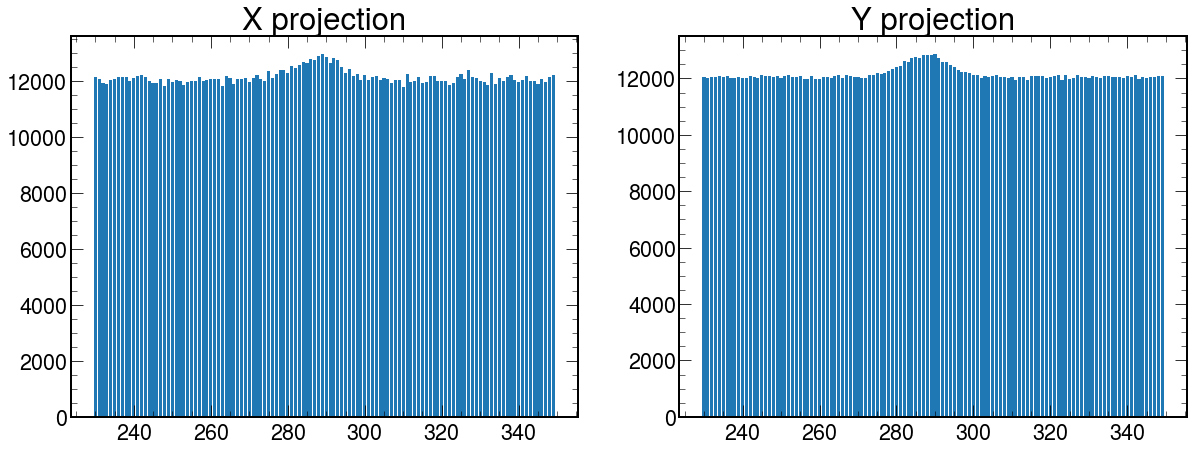

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].bar(range(obs_left, obs_right), ima_x)
axs[0].set_title('X projection')
axs[1].bar(range(obs_left, obs_right), ima_y)
axs[1].set_title('Y projection')
plt.show()

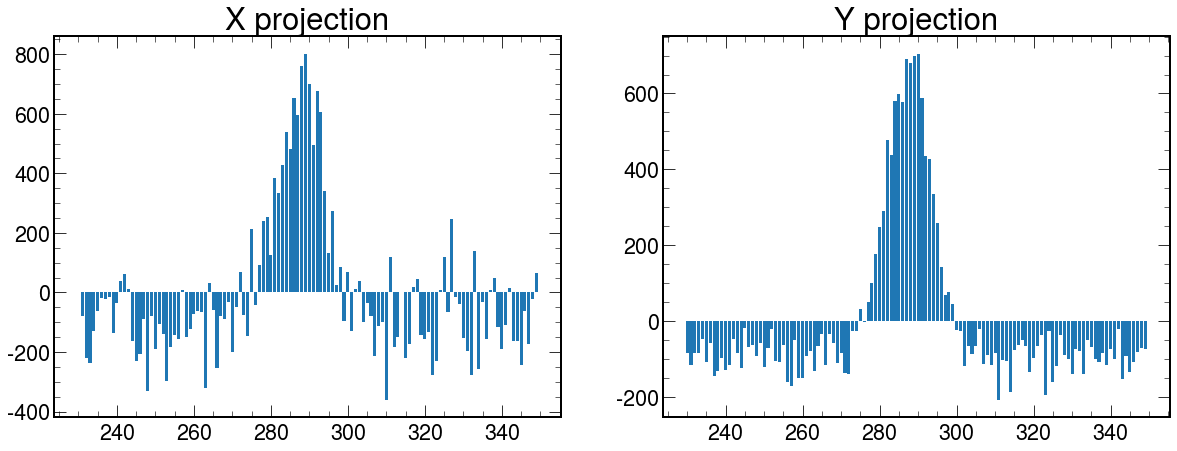

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].bar(range(obs_left, obs_right), ima_x - np.mean(ima_x)) # note that mean is biased by the signal
axs[0].set_title('X projection')
axs[1].bar(range(obs_left, obs_right), ima_y - np.mean(ima_y)) # note that mean is biased by the signal
axs[1].set_title('Y projection')
plt.show()

### model

In [11]:
# parameters
mu = zfit.Parameter("mu", obs_left + (obs_right-obs_left)/2, obs_left, obs_right)
sigma = zfit.Parameter("sigma", 10., 0.01, obs_right - obs_left)
# lambd = zfit.Parameter("lambda", -0.01, -1, -0.000001)

# model building, pdf creation
signal = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs, name='sig')
# background = zfit.pdf.Exponential(lambd, obs=obs)
background = zfit.pdf.Uniform(obs_left, obs_right, obs=obs, name='bkgr') 

# n_bkg = zfit.Parameter('n_bkg', sum(ima_x))
# n_sig = zfit.Parameter('n_sig', 1000)
# gauss_extended = gauss.create_extended(n_sig)
# exp_extended = exponential.create_extended(n_bkg)
# uni_extended = uniform.create_extended(n_bkg)
# model = zfit.pdf.SumPDF([gauss_extended, uni_extended])

fr = zfit.Parameter("fr", 0.1, 0, 1)
model = zfit.pdf.SumPDF([signal, background], fracs=fr)

### data

In [12]:
from utils import counts_to_datapoints

In [13]:
x_samples, y_samples = counts_to_datapoints(ima_x, ima_y, obs_left, obs_right)
plot_scaling_dict = {'x': len(x_samples) / n_bins * obs.area(), 'y': len(y_samples) / n_bins * obs.area()}

<ipython-input-13-e0bc18c6d68e>:2: UserWarning: The function <function Space.area at 0x2b81bf65a8b0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs',), axes=None, limits=(array([[230.]]), array([[350.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling_dict = {'x': len(x_samples) / n_bins * obs.area(), 'y': len(y_samples) / n_bins * obs.area()}


In [14]:
data_proj_dict = {'x': zfit.data.Data.from_numpy(obs=obs, array=x_samples), 'y': zfit.data.Data.from_numpy(obs=obs, array=y_samples)}
data_proj_np_dict = {'x': data_proj_dict['x'][:, 0].numpy(), 'y': data_proj_dict['y'][:, 0].numpy()}

### fitting configuration

In [15]:
# # set the values to a start value for the fit
mu.set_value(obs_left+(obs_right - obs_left)/2)
sigma.set_value(4.)
fr.set_value(0.01)

# lambd.set_value(-0.0001)
# n_sig.set_value(0.01*sum(ima_x))
# n_bkg.set_value(sum(ima_x))

# create NLL
# nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)
nll_x = zfit.loss.UnbinnedNLL(model=model, data=data_proj_dict['x'])
nll_y = zfit.loss.UnbinnedNLL(model=model, data=data_proj_dict['y'])

# create a minimizer
minimizer = zfit.minimize.Minuit(verbosity=7)
# minimizer = zfit.minimize.Adam() # and there's more

### fit X projection

In [16]:
fit_results_dict, model_proj_dict = {}, {}

In [17]:
result_x = minimizer.minimize(nll_x) # , params=[mu, frac]
result_x = minimizer.minimize(nll_x) # , params=[sigma, frac]
result_x = minimizer.minimize(nll_x)
print(result_x.params)
# # do the error calculations, here with hesse, than with minos
# param_hesse_x = result_x.hesse()
# param_errors_x, _ = result_x.errors()  # this returns a new FitResult if a new minimum was found
print(result_x.valid)  # check if the result is still valid

/nfs/dust/cms/user/filatovo/miniconda3/envs/idao/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/nfs/dust/cms/user/filatovo/miniconda3/envs/idao/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979e+06                  │         Nfcn = 83 (83 total)         │
│ EDM = 0.00505 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979e+06                  │         Nfcn = 61 (61 total)         │
│ EDM = 3.69e-06 (Goal: 0.001)     │                                      │
├───────────

In [18]:
fit_results_dict['x'] = {p.name: p.numpy() for p in model.get_params()}
model_proj_dict['x'] = {m.name: m.pdf(obs_grid).numpy() for m in model.get_models()}
model_proj_dict['x']['model'] = model.pdf(obs_grid).numpy()

In [19]:
result_x.fmin/len(x_samples)

4.787336271304148

#### fit Y projection

In [20]:
result_y = minimizer.minimize(nll_y) # , params=[mu, frac]
result_y = minimizer.minimize(nll_y) # , params=[sigma, frac]
result_y = minimizer.minimize(nll_y)
print(result_y.params)
# # do the error calculations, here with hesse, than with minos
# param_hesse_y = result_y.hesse()
# param_errors_y, _ = result_y.errors()  # this returns a new FitResult if a new minimum was found
print(result_y.valid)  # check if the result is still valid

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979e+06                  │         Nfcn = 98 (98 total)         │
│ EDM = 0.00305 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979e+06                  │         Nfcn = 93 (93 total)         │
│ EDM = 3.02e-05 (Goal: 0.001)     │                                      │
├───────────

In [21]:
fit_results_dict['y'] = {p.name: p.numpy() for p in model.get_params()}
model_proj_dict['y'] = {m.name: m.pdf(obs_grid).numpy() for m in model.get_models()}
model_proj_dict['y']['model'] = model.pdf(obs_grid).numpy()

In [22]:
result_y.fmin/len(y_samples)

4.787344978299316

### plot

In [23]:
from utils import plot_projections

In [24]:
image_name = image_path.split('/')[-1].split(';1.png')[0]
image_name

'-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269.png'

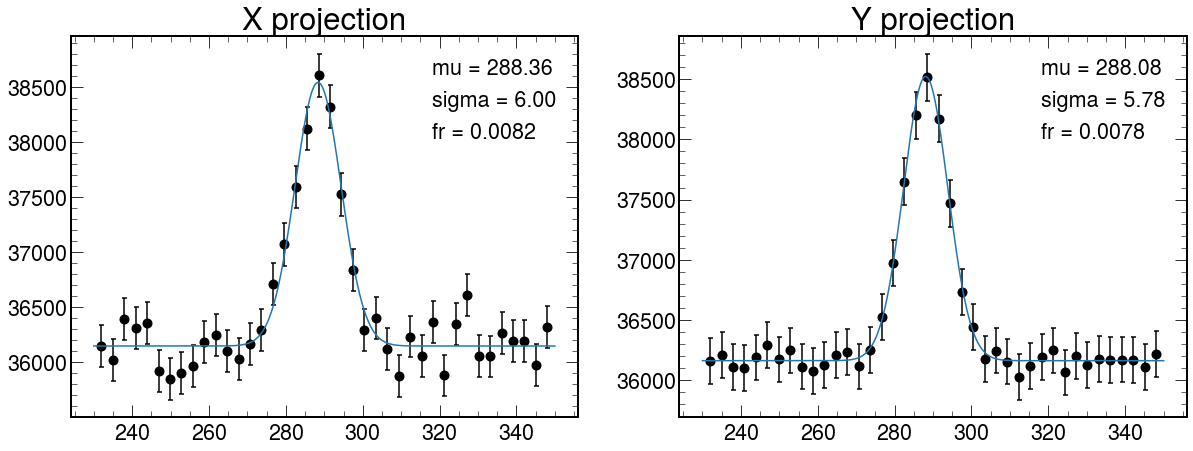

In [25]:
plot_projections(obs_grid, n_bins, data_proj_np_dict, 
                 model_proj_dict, plot_scaling_dict, fit_results_dict, 
                 savefig=False, image_name=None)

### chi2

In [26]:
from scipy.stats import chisquare

In [29]:
chisquare(sum(ima_y)* model.pdf(obs_bin_centers), ima_y, ddof=3)

Power_divergenceResult(statistic=15.620774919449598, pvalue=1.0)

In [30]:
def my_chi2(model, bin_centers, ima):
    chi2 = (sum((ima.sum()*(model.pdf(bin_centers)) - ima)**2/ima)).numpy() 
    n_dif = len(ima) - len(model.get_params())
    return chi2, n_dif

In [31]:
my_chi2(model, obs_bin_centers, ima_x)

(120.89602743839959, 117)

In [32]:
my_chi2(model, obs_bin_centers, ima_y)

(15.620774919449604, 117)

### fit errors

In [33]:
result_x.info['original']

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.979e+06                  │         Nfcn = 61 (61 total)         │
│ EDM = 4.15e-06 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [34]:
dict(result_x.info['original'])

{'fval': 6979179.884430582,
 'edm': 4.145083626802416e-06,
 'tolerance': 1.0,
 'nfcn': 61,
 'nfcn_total': 61,
 'up': 0.5,
 'is_valid': True,
 'has_valid_parameters': True,
 'has_accurate_covar': True,
 'has_posdef_covar': True,
 'has_made_posdef_covar': False,
 'hesse_failed': False,
 'has_covariance': True,
 'is_above_max_edm': False,
 'has_reached_call_limit': False,
 'has_parameters_at_limit': False,
 'ngrad': 0,
 'ngrad_total': 0}

In [35]:
param_hesse_x = result_x.hesse()
# param_errors, _ = result.errors()  # this returns a new FitResult if a new minimum was found
print(result_x.valid, result_x.converged)  # check if the result is still valid

True True


In [36]:
param_hesse_x

OrderedDict([(<zfit.Parameter 'fr' floating=True value=0.007824>,
              {'error': 0.0005466418091783085}),
             (<zfit.Parameter 'mu' floating=True value=288.1>,
              {'error': 0.36787489251803335}),
             (<zfit.Parameter 'sigma' floating=True value=5.781>,
              {'error': 0.42883426341219566})])

### features

* fraction
* total sum of pixel deposits
* fr*sum
* mean+error, sigma+error (X and Y)
* sigma_x - sigma_y
* mean_x - mean_y
* chi2, p-value (X and Y): sig+bkgr
* chi2, p-value (X and Y): bkgr
* fcn value (X and Y)
* n_bins > mean background (X and Y)
* fr*sum/n_bins
* result_x.info['original']

### save to dataframe

* keep amongst features "image_name" along with parsed info